In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

from tensorflow.keras import losses

from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

In [0]:

(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()


X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)


X_train = X_train / X_train.max()
X_test = X_test / X_test.max()


y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

In [0]:
indices = np.random.randint(X_train.shape[0], size=3000)

In [0]:
enc_1 = Dense(100, activation='tanh')
enc_2 = Dense(2, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='exponential')
dec_1 = Dense(784, activation='sigmoid')

In [0]:
x = Input(shape=(784,))
enc_x = enc_2(enc_1(x))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [0]:

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [0]:

z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(z_input))

In [144]:
x_hat = dec_1(dec_2(z))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_63 (Dense)                (None, 100)          78500       input_21[0][0]                   
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 2)            202         dense_63[0][0]                   
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 2)            6           dense_64[0][0]                   
___________________________________________________________________________________________

In [0]:

reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [0]:
VAE.compile(optimizer=Adam())

In [150]:
VAE.fit(X_train, X_train, 
        batch_size=333, 
        epochs=10)

Epoch 1/10
181/181 [==============================] - 3s 15ms/step - loss: 39.0836
Epoch 2/10
181/181 [==============================] - 3s 14ms/step - loss: 39.0298
Epoch 3/10
181/181 [==============================] - 3s 14ms/step - loss: 39.0508
Epoch 4/10
181/181 [==============================] - 3s 14ms/step - loss: 39.0295
Epoch 5/10
181/181 [==============================] - 3s 15ms/step - loss: 39.0216
Epoch 6/10
181/181 [==============================] - 3s 16ms/step - loss: 38.9989
Epoch 7/10
181/181 [==============================] - 3s 15ms/step - loss: 39.0087
Epoch 8/10
181/181 [==============================] - 3s 15ms/step - loss: 39.0147
Epoch 9/10
181/181 [==============================] - 2s 14ms/step - loss: 39.0067
Epoch 10/10
181/181 [==============================] - 2s 13ms/step - loss: 39.0167


In [67]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 202       
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 6         
Total params: 78,708
Trainable params: 78,708
Non-trainable params: 0
_________________________________________________________________


In [0]:
VAE_latents = VAE_Encoder.predict(X_train[indices])

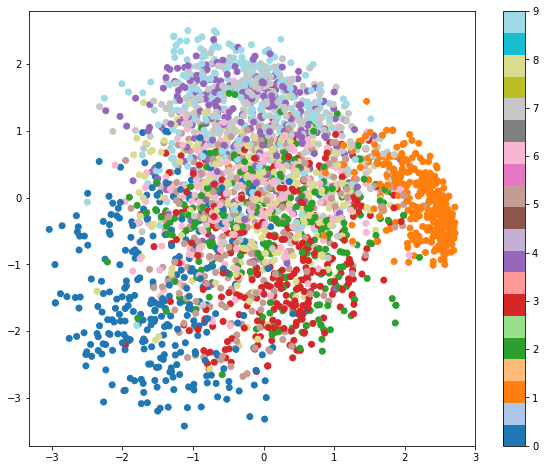

In [52]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

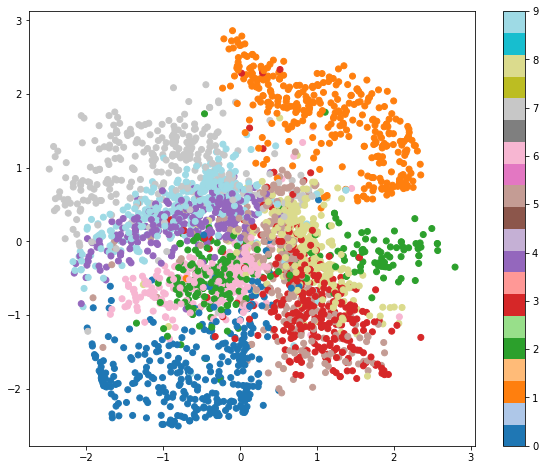

In [69]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [71]:
enc_1 = Dense(100, activation='elu')
enc_2 = Dense(2, activation='selu')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='selu')
dec_1 = Dense(784, activation='elu')
x = Input(shape=(784,))
enc_x = enc_2(enc_1(x))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(z_input))
x_hat = dec_1(dec_2(z))

VAE = Model(x, x_hat)
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)
VAE.compile(optimizer=SGD(lr=0.006)
VAE.fit(X_train, X_train, batch_size=256, epochs=10)
VAE_Encoder = Model(x, z_mean)
VAE_latents = VAE_Encoder.predict(X_train[indices])
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

SyntaxError: ignored

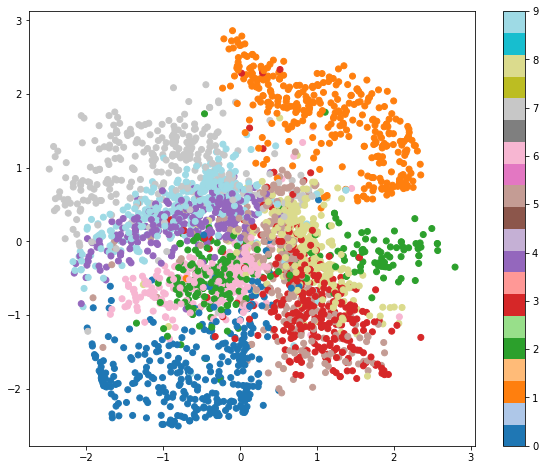

In [94]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

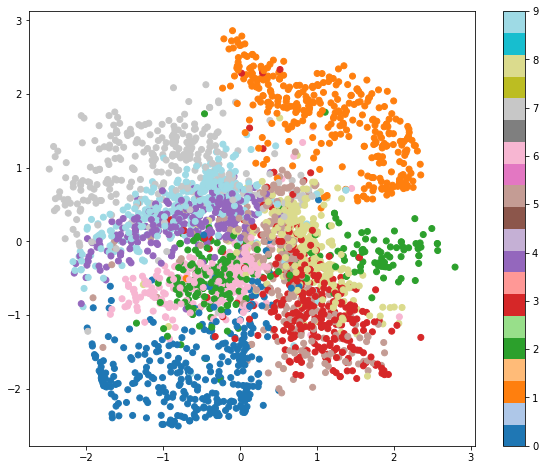

In [125]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

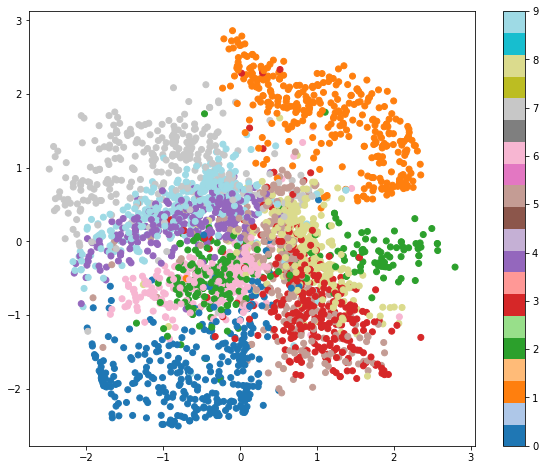

In [127]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()